# Reinforcement Learning
Prof. Milica Gašić

### Advantage Actor-Critic

**Policy Gradient with Deep Learning**:  
In general, the update rule of policy gradient can be written as:
$$
\theta \leftarrow \theta + \alpha \, \Phi_t \nabla_\theta \log \pi_\theta(a_t | s_t)
$$
where $\theta$ is the weight vector, $\alpha$ is the learning rate, and $\Phi_t \in \mathbb{R}$ indicates how good it was to select the action $a_t$ in the state $s_t$.  
But how can this applied to deep learning, where $\pi_\theta(a_t | s_t)$ is computed by a neural network with weights $\theta$?  
The solution is to write down a "pseudo" loss function that will result in the same gradients via backpropagation:
$$
\mathcal{L}_\text{PG}(\theta) = \mathbb{E}_{\pi_\theta} \left[ -\Phi_t \log \pi_\theta(A_t | S_t) \right]
$$
This means that we don't have to compute the score function anymore, but only the log-probabilities,  
and the automatic differentiation library (e.g., PyTorch) will do the rest for us.

**Advantage Actor-Critic**:  
In the lecture we have seen that the high variance of policy gradients can be reduced with a critic (= learned value function).  
Advantage actor-critic approximates the advantage function with the TD error and uses it for $\Phi_t$, i.e.,
$$
\Phi_t = \underbrace{r_{t+1} + \gamma \hat{v}(s_{t+1}, w)}_\text{TD target} - \hat{v}(s_t, w)
$$
where $\hat{v}$ is a learned value function with weights $w$. The value function can be trained with any VFA method.  
We will consider the usual mean squared error between the TD target and the prediction (semi-gradient TD):
$$
\mathcal{L}_\text{VF}(w) = \mathbb{E}_{\pi_\theta} \left[ \text{sg}(\underbrace{R_{t+1} + \gamma \hat{v}(S_{t+1}, w)}_\text{TD target}) - \hat{v}(S_t, w) \right]
$$
where $\text{sg}$ is the stop-gradient operator that indicates that no gradients will be backpropagated at this point (= `detach()` in PyTorch).  
Note that the TD target is used in both losses and only needs to be computed once.

In summary, advantage actor-critic trains two neural networks:
- *Actor*: The policy network that computes $\pi_\theta(a | s)$.
- *Critic*: The value function network that computes $\hat{v}(s, w)$.

**Softmax Policy**:  
We will again use a softmax policy, where the scores (also called "logits") are computed by the neural network,  
which are then normalized to a probability distribution using the softmax function.

More formally, the actor network $f_\theta$ computes a vector of scores $y = f_\theta(s) \in \mathbb{R}^M$, where $M$ is the number of actions.  
Then the policy is computed with:
$$
\pi_\theta(a | s) = \frac{\exp(y_a)}{\sum_{a'} \exp(y_{a'})}
$$
This can be implemented efficiently using the `torch.softmax()` function.  
(https://pytorch.org/docs/stable/generated/torch.softmax.html)

For the loss function of the actor, we need to compute the logarithm of the policy:  
$$
\log \pi_\theta(a | s) = y_a - \log \sum_{a'} \exp(y_{a'})
$$
The first term selects the score of the selected action.  
The second term can be implemented efficiently and numerically stable using the `torch.logsumexp()` function.  
(https://pytorch.org/docs/stable/generated/torch.logsumexp.html)

**Stochastic Gradient Descent**:  
Deep neural networks are trained with stochastic gradient descent, where *batches* of states, actions, and rewards are used for each update.  
For DQN we can use experience replay to create batches from old transitions that we have collected, since Q-learning is an off-policy method.  
But in the case of on-policy policy gradient, we cannot reuse old transitions and always have to use new data from the environment.

A common approach to obtain batches for the on-policy setting is to create *multiple instances* of the environment.  
For example, we can create $16$ instances of the same environment and call the `step()` function for all of them at each iteration.  

**Algorithm**:  
To summarize, this is a rough description of the algorithm we will use:  
- Create $N$ environment instances
- Reset all environment instances to obtain a batch of $N$ states
- Loop forever:  
  - Select a batch of $N$ actions using the policy $\pi_\theta$
  - Sample transitions from all environment instances, to obtain a batch of rewards and next states
  - Update the actor and critic network by minimizing the losses $\mathcal{L}_\text{PG}$ and $\mathcal{L}_\text{VF}$

### Implementation

Make sure that the files `rl_gui.py` and `rl_tests.py` are in the same folder as the notebook.

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

import rl_gui
import rl_tests

#### Actor-Critic Agent

The class `AdvantageActorCritic` is a subclass of `torch.nn.Module`, which takes care of the automatic differentiation.  
It contains both networks for the actor and the critic.  
Your task is to finish the implementation.

We provide two utility functions that might be helpful:

In [2]:
def select_at_index(x, indices):
    # Extracts the elements from x at the specified indices, i.e.,
    # result[i] = x[i, indices[i]] for all i.
    # - x has shape (batch_size, d)
    # - indices has shape (batch_size)
    # - the result has shape (batch_size)
    return x.gather(-1, indices.unsqueeze(-1)).squeeze(-1)

def sample_categorical(probs):
    # Samples from a categorical distribution (e.g. with probabilities computed with softmax).
    # - probs has shape (batch_size, d)
    # - the result has shape (batch_size)
    return torch.multinomial(probs, 1, replacement=True).squeeze(1)

In [4]:
class AdvantageActorCritic(nn.Module):

    def __init__(self, state_dim, num_actions, gamma):
        super().__init__()
        self.gamma = gamma  # discount factor

        # actor network
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )

        # critic network
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def select_actions(self, states):
        # states has shape (batch_size, state_dim)
        # compute the scores for the given states
        scores = self.actor(states)
        # scores has shape (batch_size, num_actions)
        #######################################################################
        # TODO Convert the computed scores to probabilities with the softmax  #
        # function and sample a batch of actions.                             #
        #######################################################################

        probs = torch.softmax(scores, dim=1)
        actions = sample_categorical(probs)

        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        return actions

    def compute_log_probs(self, states, actions):
        # states has shape (batch_size, state_dim)
        # actions has shape (batch_size)
        # compute the scores for the given states
        scores = self.actor(states)
        # scores has shape (batch_size, num_actions)
        #######################################################################
        # TODO Compute the log-probabilities as described above for the given #
        # batches of states and actions. You can use one of the utility       #
        # functions and torch.logsumexp().                                    #
        #######################################################################

        log_probs = scores - torch.logsumexp(scores, dim=1, keepdim=True)
        log_probs = select_at_index(log_probs, actions)

        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        return log_probs

    def compute_values(self, states):
        # states has shape (batch_size, state_dim)
        # compute values for the batch of states using the critic network
        values = self.critic(states).squeeze(-1)
        # values has shape (batch_size)
        return values

    def compute_td_targets(self, rewards, next_states, terminations):
        # next_states has shape (batch_size, state_dim)
        # rewards and terminations have shape (batch_size)

        gamma = self.gamma  # discount factor

        # turn off gradient computation
        with torch.no_grad():
            #######################################################################
            # TODO Compute the batch of TD targets, i.e., the reward plus the     #
            # discounted value of the next state. Remember that the next value    #
            # should not be used for terminal states.                             #
            #######################################################################

            next_values = self.compute_values(next_states)
            # if the state is terminal, the value of the next state is 0
            next_values = next_values * (~terminations)
            td_target = rewards + gamma * next_values

            #######################################################################
            # End of your code.                                                   #
            #######################################################################

        return td_target

    def compute_loss(self, states, actions, td_targets):
        # states has shape (batch_size, state_dim)
        # actions, rewards, next_states, and terminations have shape (batch_size)
        #######################################################################
        # TODO Compute the loss for the actor (L_PG) and the critic (L_VF) as #
        # described above. The expectations are approximated by taking the    #
        # average over the batch (i.e., use `x.mean()`).                      #
        # IMPORTANT: Apply the stop-gradient operator to the advantages (phi) #
        # by using `x.detach()`, since we don't want to backpropagate from    #
        # the loss of the actor to the critic network.                        #
        #######################################################################

        # compute the log-probabilities for the given states and actions
        log_probs = self.compute_log_probs(states, actions)
        # compute the values for the given states
        values = self.compute_values(states)
        # compute the advantages
        phi = td_targets - values

        # compute the policy gradient loss
        actor_loss = -(log_probs * phi.detach()).mean()

        # compute the value function loss
        critic_loss = (phi ** 2).mean()

        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        # return both losses
        return actor_loss, critic_loss

You can use the following code cell to test your implementation.  
**Important**: After changing your code, execute the above code cell before running the tests.

In [5]:
def test_actor_critic():
    torch.manual_seed(42)
    rng = np.random.Generator(np.random.PCG64(seed=42))
    state_dim = 5
    num_actions = 3
    gamma = 0.8
    ac = AdvantageActorCritic(state_dim, num_actions, gamma)
    with torch.no_grad():
        for layer in (ac.actor[0], ac.actor[2], ac.actor[4], ac.critic[0], ac.critic[2], ac.critic[4]):
            mean = rng.uniform(-0.5, 0.5)
            layer.weight[:] = torch.as_tensor(rng.normal(mean, 0.1, layer.weight.shape))
            nn.init.zeros_(layer.bias)

    sample_states = lambda batch_size: torch.as_tensor(rng.standard_normal((batch_size, state_dim), dtype=np.float32))
    sample_actions = lambda batch_size: torch.as_tensor(rng.choice(num_actions, batch_size))

    yield 'select_actions()'
    for expected_actions in [
        [0, 1, 0, 2, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0]
    ]:
        batch_size = len(expected_actions)
        states = sample_states(batch_size)
        actions = ac.select_actions(states)
        #print(actions)
        #print(torch.as_tensor(expected_actions))
        if (yield from rl_tests.check_torch_tensor(actions, 'actions', shape=(batch_size,), dtype=torch.long)):
            yield torch.all(actions == torch.as_tensor(expected_actions)).item(), 'actions are incorrect (can only be tested if you use torch.multinomial)'
        yield None

    yield 'compute_log_probs()'
    for expected_log_probs in [
        [-1.37329102e-04, -1.10322797e+00, -6.56127930e-04],
        [-1.14602625, -14.17874146, -44.21386719,   0.00000000,  -1.09861231],
        [-1.52587891e-05, -1.09861231e+00]
    ]:
        batch_size = len(expected_log_probs)
        expected_log_probs = torch.as_tensor(expected_log_probs)
        states = sample_states(batch_size)
        actions = sample_actions(batch_size)
        log_probs = ac.compute_log_probs(states, actions)
        if (yield from rl_tests.check_torch_tensor(log_probs, 'log_probs', shape=(batch_size,), dtype=torch.float32)):
            yield torch.allclose(log_probs, torch.as_tensor(expected_log_probs)), f'log_probs are incorrect (error = {torch.sum(torch.abs(log_probs - expected_log_probs)).item()})'
        yield None

    yield 'compute_td_targets()'
    for expected_td_targets in [
        [-1.1166, -0.3763,  0.1678, -0.1645],
        [-1.0284, -0.8361,  1.0379, -1.6344,  1.1361],
        [-0.9384,  0.2974, -1.0340, -0.8565, -0.1211, -0.9041, -0.6611]
    ]:
        batch_size = len(expected_td_targets)
        expected_td_targets = torch.as_tensor(expected_td_targets)
        rewards = torch.randn(batch_size, dtype=torch.float32)
        next_states = sample_states(batch_size)
        terminations = torch.rand(batch_size) < 0.5
        td_targets = ac.compute_td_targets(rewards, next_states, terminations)
        if (yield from rl_tests.check_torch_tensor(td_targets, 'td_targets', shape=(batch_size,), dtype=torch.float32)):
            yield torch.allclose(td_targets, torch.as_tensor(expected_td_targets), atol=1e-04), f'td_targets are incorrect (error = {torch.sum(torch.abs(td_targets - expected_td_targets)).item()})'
        yield None

    yield 'compute_loss()'
    for batch_size, expected_actor_loss, expected_critic_loss in [
        (4, 8.9347, 0.5728),
        (8, 0.2931, 0.5197),
        (12, -2.5311, 0.9795)
    ]:
        states = sample_states(batch_size)
        actions = sample_actions(batch_size)
        td_targets = torch.randn(batch_size, dtype=torch.float32)
        actor_loss, critic_loss = ac.compute_loss(states, actions, td_targets)
        if (yield from rl_tests.check_torch_tensor(actor_loss, 'actor_loss', shape=tuple(), dtype=torch.float32)):
            expected_actor_loss = torch.tensor(expected_actor_loss)
            yield torch.isclose(actor_loss, expected_actor_loss, atol=1e-04), f'actor_loss is incorrect (error = {(actor_loss - expected_actor_loss).item()})'
            yield actor_loss.requires_grad, 'gradients disabled for actor_loss'
        if (yield from rl_tests.check_torch_tensor(critic_loss, 'critic_loss', shape=tuple(), dtype=torch.float32)):
            expected_critic_loss = torch.tensor(expected_critic_loss)
            yield torch.isclose(critic_loss, expected_critic_loss, atol=1e-04), f'critic_loss is incorrect (error = {(actor_loss - expected_critic_loss).item()})'
            yield critic_loss.requires_grad, 'gradients disabled for critic_loss'
        yield None

    yield 'gradients'
    optimizer = optim.SGD(ac.parameters(), lr=0.1)
    states = sample_states(batch_size)
    actions = sample_actions(batch_size)
    td_targets = torch.randn(batch_size, dtype=torch.float32)

    critic_params = tuple(param.data.clone() for param in ac.critic.parameters())
    optimizer.zero_grad()
    actor_loss, critic_loss = ac.compute_loss(states, actions, td_targets)
    actor_loss.backward()
    optimizer.step()
    yield all(torch.all(new == old).item() for new, old in zip(ac.critic.parameters(), critic_params)), \
        'The weights of the critic network have changed after minimizing the actor_loss. Did you use x.detach() on the advantages?'

    actor_params = tuple(param.data.clone() for param in ac.actor.parameters())
    optimizer.zero_grad()
    actor_loss, critic_loss = ac.compute_loss(states, actions, td_targets)
    critic_loss.backward()
    optimizer.step()
    yield all(torch.all(new == old).item() for new, old in zip(ac.actor.parameters(), actor_params)), \
        'The weights of the actor network have changed after minimizing the critic_loss.'

    yield None


rl_tests.run_tests(test_actor_critic())

Testing select_actions()...
3/3 tests passed!

Testing compute_log_probs()...
3/3 tests passed!

Testing compute_td_targets()...
3/3 tests passed!

Testing compute_loss()...
3/3 tests passed!

Testing gradients...
1/1 tests passed!


### Evaluation

We will evaluate the algorithm on the LunarLander environment.  
Please read the documentation: https://gymnasium.farama.org/environments/box2d/lunar_lander/

If an error occurs, you might have to install the `box2d` environments first:  
`pip install gymnasium[box2d]`

In [6]:
def create_env(seed):
    env_id = 'LunarLander-v3'
    env = gym.make(env_id, render_mode='rgb_array')
    env.reset(seed=seed)
    return env

Evaluate a random policy:

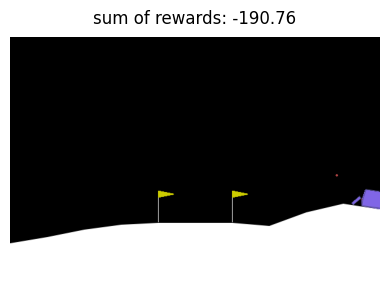

In [7]:
env = create_env(seed=42)
render = rl_gui.create_renderer(env, fps=60, figsize=(4, 3))

env.reset()
render()
reward_sum = 0.0
for _ in range(200):
    action = env.action_space.sample()
    _, reward, terminated, truncated, _ = env.step(action)
    reward_sum += reward
    render(f'sum of rewards: {reward_sum:.2f}')
    if terminated or truncated:
        break

Train the policy using advantage actor-critic.  
We have provided some hyperparameters as a starting point, but the results are not optimal.  
Feel free to change the hyperparameters and try to find a better solution.  
You can also try to change the neural network architecture.

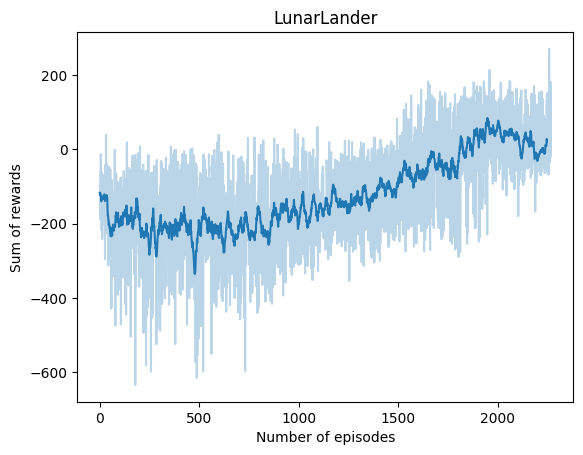

In [ ]:
alpha = 1e-4       # learning rate
gamma = 0.9       # discount factor
num_envs =  128     # number of environment instances (= batch size)
num_steps = 50000 # number of iterations

# create the environment instances, initialize with different random seeds
envs = [create_env(seed=i) for i in range(num_envs)]

# create the actor-critic agent and the optimizer
state_dim = envs[0].observation_space.shape[0]
num_actions = envs[0].action_space.n
ac = AdvantageActorCritic(state_dim, num_actions, gamma)
optimizer = optim.Adam(ac.parameters(), lr=alpha)

# reset all environment instances
states = []
for env in envs:
    state, _ = env.reset()
    states.append(state)

# convert batch of initial states to tensor
states = torch.as_tensor(np.array(states))

# only for plotting
reward_sums = torch.zeros(num_envs)
episode_rewards = []

for _ in range(num_steps):
    ac.eval()  # switch to evaluation mode
    # select batch of actions given the batch of states
    actions = ac.select_actions(states)

    # step all environment instances and store results in these lists:
    rewards = []
    next_states = []
    terminations = []
    truncations = []
    for i in range(num_envs):
        action = actions[i].item()
        next_state, reward, terminated, truncated, _ = envs[i].step(action)
        rewards.append(reward)
        next_states.append(next_state)
        terminations.append(terminated)
        truncations.append(truncated)

    # convert the lists to tensors
    rewards = torch.as_tensor(np.array(rewards, dtype=np.float32))
    next_states = torch.as_tensor(np.array(next_states))
    terminations = torch.as_tensor(np.array(terminations))
    truncations = torch.as_tensor(np.array(truncations))

    # optimize the actor and critic networks
    ac.train()  # switch to training mode
    optimizer.zero_grad()
    td_targets = ac.compute_td_targets(rewards, next_states, terminations)
    actor_loss, critic_loss = ac.compute_loss(states, actions, td_targets)
    # to minimize both losses simultaneously, just sum them up
    total_loss = actor_loss + critic_loss
    total_loss.backward()
    optimizer.step()

    # necessary for next iteration
    states = next_states

    reward_sums += rewards
    dones = terminations | truncations
    if dones.any():
        # reset the environment instances that were terminated or truncated
        for i in range(num_envs):
            if dones[i]:
                state, _ = envs[i].reset()
                states[i] = torch.as_tensor(state)

        # only for plotting
        episode_rewards.extend(reward_sums[dones].tolist())
        reward_sums[dones] = 0

plt.title('LunarLander')
plt.xlabel('Number of episodes')
plt.ylabel('Sum of rewards')
plt.plot(episode_rewards, c='C0', alpha=0.3)
plt.plot(np.convolve(episode_rewards, np.ones(20) / 20, mode='valid'), c='C0');

Evaluate the learned policy:

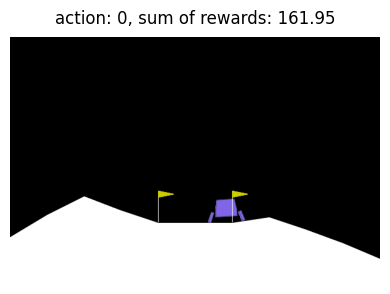

In [13]:
render = rl_gui.create_renderer(env, fps=60, figsize=(4, 3))

state, _ = env.reset()
render()
reward_sum = 0.0

ac.eval()

while True:
    action = ac.select_actions(torch.as_tensor(state).unsqueeze(0)).item()
    state, reward, terminated, truncated, _ = env.step(action)
    reward_sum += reward
    render(f'action: {action}, sum of rewards: {reward_sum:.2f}')
    if terminated or truncated:
        break